In [87]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_confusion_ALL'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
cv = LeaveOneOut()

decoder = LinearSVC()

In [7]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

def do_test_across(patterns_train, labels_train, patterns_test, labels_test, **args):
    x, y, _, _ = combine_train_test_patterns(patterns_train, labels_train, train_test_split=1, **args)
    xT, yT, _, _ = combine_train_test_patterns(patterns_test, labels_test, train_test_split=1, **args)
    decoder.fit(x, t)
    return decoder.score(xT, yT)

In [8]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells, test_labels_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells, test_labels_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [9]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(axis='both', bottom=False, left=False,pad=0)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
dhpc_all_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_expo_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_pre_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36', #,'dhpcg20' #dHPC20 performed very well on day 1 (d' = 2)
dhpc_d2_animals =  'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_post_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_renew_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext2_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext1_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'

vhpc_all_animals  = np.loadtxt('../allmice.txt', dtype=str)
vhpc_expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
vhpc_pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
vhpc_d2_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
vhpc_post_animals = np.loadtxt('../post_mice.txt', dtype=str)
vhpc_renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93','91b','92b','93b'
vhpc_ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
vhpc_ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [11]:
sessions = 'expo', 'pre', 'd2', 'post', 'ext1', 'ext2', 'renew'

In [12]:
regions = 'dhpc','vhpc'

In [56]:
dark_co = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Day2','Late','Ext1','Ext2','Reinstate')

In [14]:
for reg in regions:
    for sess in sessions:
        if sess == 'expo':
            exec("patterns_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/2_odor_expo/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/2_odor_expo/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,reg,sess))
        else:
            exec("patterns_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))

for reg in regions:
    for sess in sessions:
        for var in ('time_ax', 'traces', 'events', 'cycles',
            'is_STIM1t', 'is_STIM2t', 'is_STIM3t', 'is_STIM4t','CYCLE_START', 'CS_DURATION', 'DELAY'):
            exec ('%s_%s_%s = {}'%(var,reg, sess))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                if sess == 'expo':
                    folder = '../%s/4_odor_expo/notebooks/autorestore/preprocessing'%(ani)
                else:
                    folder = '../%s/%s/notebooks/autorestore/preprocessing'%(ani,sess)
                try:
                    eval('%s_%s_%s'%(var,reg,sess)).update({ani: ut.load_variable(var, folder)})
                except IOError:
                    print 'error'
                    continue

for reg in regions:
    for sess in sessions:
        exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels_%s',\
                                    '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                    for ani in %s_%s_animals]))"%(reg,sess, reg,sess, sess, reg,sess))

for reg in regions:
    for tb in bins:
        for sess in sessions:
            try:
                exec("patterns_%s_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))
            except:
                print 'nope %s %s'%(tb,sess)

In [15]:
for reg in regions:
    for sess in sessions:
        for t in range(16):
                exec('patterns_%s_%s_%s = {}'%(reg,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(reg,sess,t,ani,reg,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue

# now loop and concatenate results to get "average" predictions

In [66]:
loops=100

In [67]:
%%time
# predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in sessions:
        print reg,sess,"...  ",
        for t in range(16): # number of time bins
            for n in range(loops):
                exec("predictions_%s_%s_%s_%s, test_labels_%s_%s_%s = do_predict_within(patterns_%s_%s_%s,\
                    labels_%s_%s,classes=range(2))"%(reg,sess,t,n,reg,sess,n,reg,sess,t,reg,sess))

computing loop: dhpc expo ...   dhpc pre ...   dhpc d2 ...   dhpc post ...   dhpc ext1 ...   dhpc ext2 ...   dhpc renew ...   vhpc expo ...   vhpc pre ...   vhpc d2 ...   vhpc post ...   vhpc ext1 ...   vhpc ext2 ...   vhpc renew ...  CPU times: user 7h 32min 47s, sys: 25min 15s, total: 7h 58min 2s
Wall time: 19min 55s



In [68]:
#append all loops
for reg in regions:
    for sess in sessions:
        for t in range(16): # number of time bins
                exec("predictions_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_0,predictions_%s_%s_%s_1)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t))
                exec("test_labels_%s_%s_appended = np.append(test_labels_%s_%s_0,test_labels_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("predictions_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_appended,predictions_%s_%s_%s_%s)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t,n))
                    exec("test_labels_%s_%s_appended = np.append(test_labels_%s_%s_appended,test_labels_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [69]:
for reg in regions:
    for sess in sessions:
            for t in range(16): # number of time bins
                exec('conf_matr_%s_%s_%s_appended = confusion_matrix(test_labels_%s_%s_appended,\
                      predictions_%s_%s_%s_appended)'%(reg,sess,t,reg,sess,reg,sess,t))

In [70]:
for reg in regions:
    for sess in sessions:
            exec("heatmaps_%s_%s = []")%(reg,sess)
            for t in range(16): # number of time bins
                exec("heatmaps_%s_%s.append(conf_matr_%s_%s_%s_appended)"%(reg,sess,reg,sess,t))


In [71]:
print heatmaps_vhpc_pre[6]
print np.sum(heatmaps_vhpc_pre[6])
print (heatmaps_vhpc_pre[6]/5000.0)
print (4.*heatmaps_vhpc_pre[6]/np.sum(heatmaps_vhpc_pre[6]),1)

[[7392 2608]
 [2115 7885]]
20000
[[ 1.4784  0.5216]
 [ 0.423   1.577 ]]
(array([[ 1.4784,  0.5216],
       [ 0.423 ,  1.577 ]]), 1)


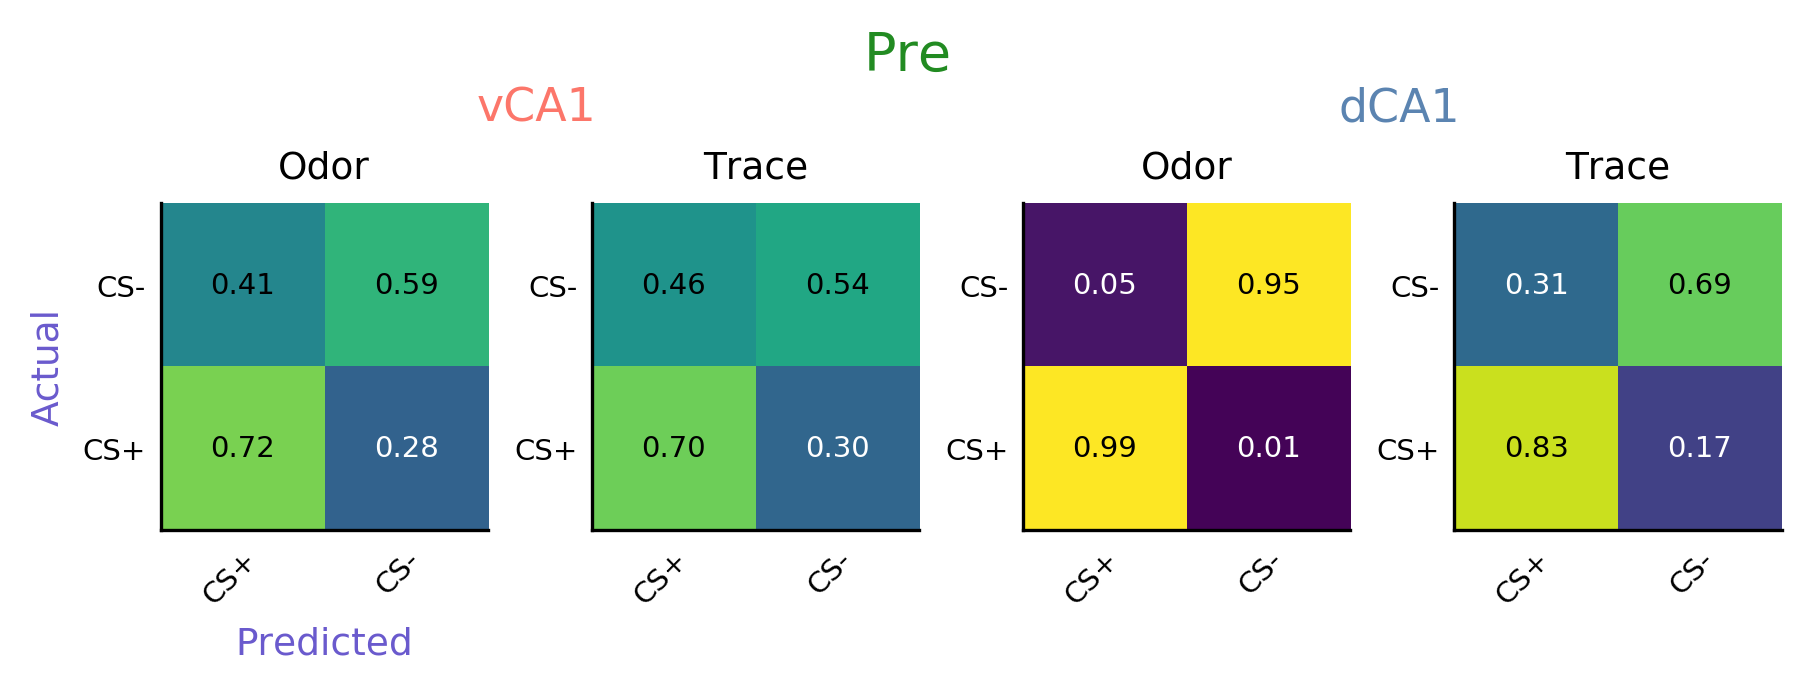

In [72]:
# plot 'em all

fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_expo[i]/np.sum(heatmaps_%s_expo[i])"%(reg,reg)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontsize=11,ha='center')

pl.suptitle('Pre',color='forestgreen', fontsize=13,y=.95)
pl.tight_layout(h_pad=4)
pl.show()
#fig.savefig('../figures/%s_confmat_dv_1s_expo.pdf'%NOTEBOOK_NAME)

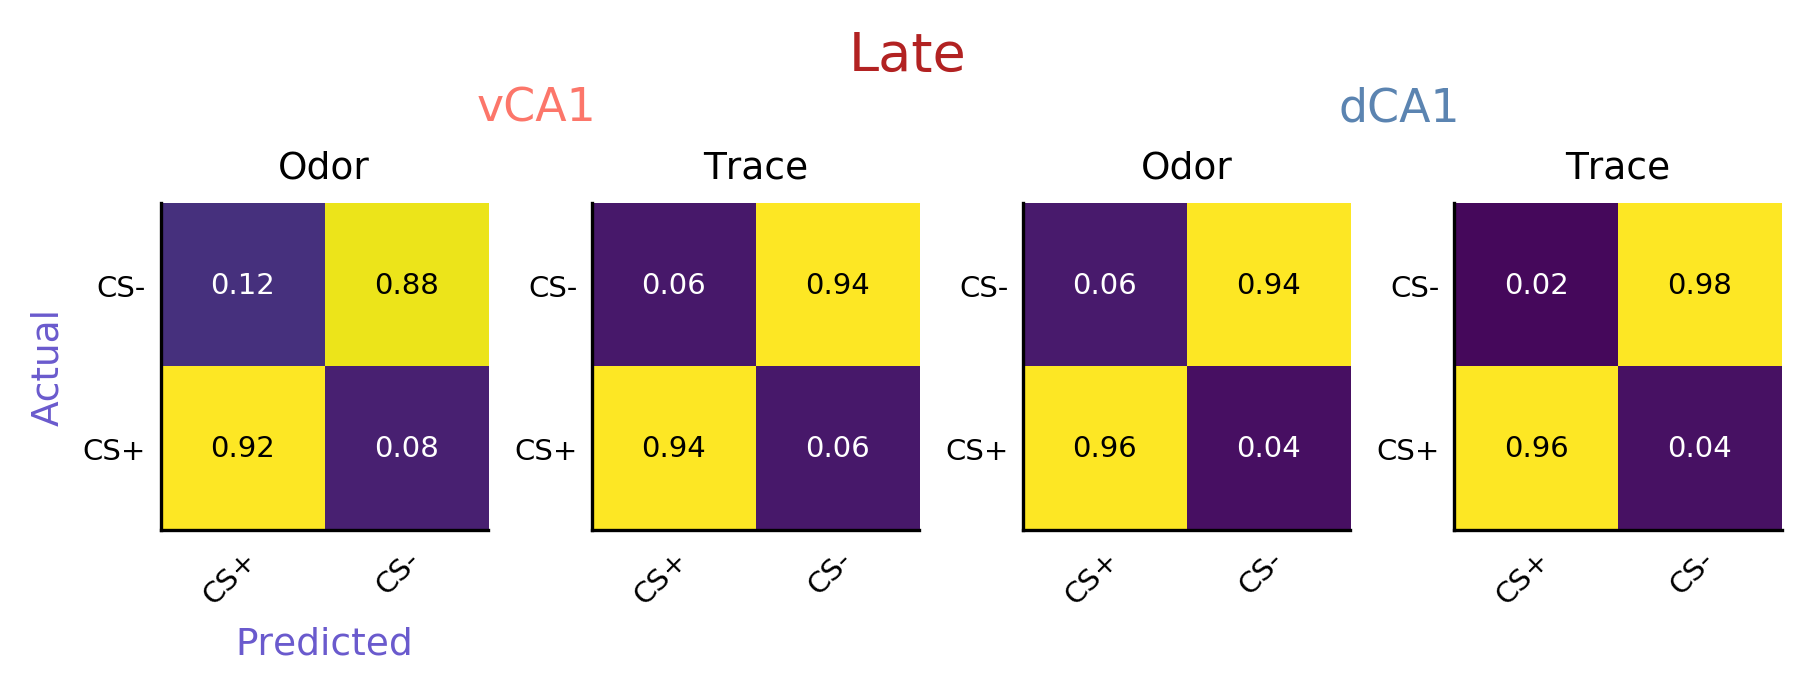

In [73]:
# plot 'em all

fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_post[i]/np.sum(heatmaps_%s_post[i])"%(reg,reg)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontsize=11,ha='center')

pl.suptitle('Late',color='firebrick', fontsize=13,y=.95)
pl.tight_layout(h_pad=4)
pl.show()
#fig.savefig('../figures/%s_confmat_dv_1s_expo.pdf'%NOTEBOOK_NAME)

# now min cells across regions and sessions (454)

In [37]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_expo', 'total_cells_pre', 'total_cells_post','total_cells_ext1','total_cells_ext2','total_cells_renew']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_vhpc/')
    exec('%s_vHPC = what'%(tot))
    print '%s_vHPC ='%(tot),
    print what

total_cells_expo_vHPC = 563
total_cells_pre_vHPC = 521
total_cells_post_vHPC = 454
total_cells_ext1_vHPC = 475
total_cells_ext2_vHPC = 518
total_cells_renew_vHPC = 473


In [38]:
#get number of vdPC cells used for decoding
cell_total = ['total_cells_expo', 'total_cells_pre', 'total_cells_post','total_cells_ext1','total_cells_ext2','total_cells_renew']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_dhpc/')
    exec('%s_dHPC = what'%(tot))
    print '%s_dHPC ='%(tot),
    print what

total_cells_expo_dHPC = 732
total_cells_pre_dHPC = 578
total_cells_post_dHPC = 842
total_cells_ext1_dHPC = 714
total_cells_ext2_dHPC = 759
total_cells_renew_dHPC = 668


In [41]:
gmin = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
print gmin

454


In [74]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in sessions:
        print reg,sess,"...  ",
        for t in range(16): # number of time bins
            for n in range(loops):
                exec("predictions_%s_%s_%s_%s_gmin, test_labels_%s_%s_%s_gmin = do_predict_within(patterns_%s_%s_%s,\
                    labels_%s_%s,classes=range(2),n_cells=gmin)"%(reg,sess,t,n,reg,sess,n,reg,sess,t,reg,sess))

computing loop: dhpc expo ...   dhpc pre ...   dhpc d2 ...   dhpc post ...   dhpc ext1 ...   dhpc ext2 ...   dhpc renew ...   vhpc expo ...   vhpc pre ...   vhpc d2 ...   vhpc post ...   vhpc ext1 ...   vhpc ext2 ...   vhpc renew ...  CPU times: user 11h 35min 17s, sys: 48min 14s, total: 12h 23min 32s
Wall time: 31min 7s



In [75]:
#append all loops
for reg in regions:
    for sess in sessions:
        for t in range(16): # number of time bins
            exec("predictions_%s_%s_%s_appended_gmin = np.append(predictions_%s_%s_%s_0_gmin,predictions_%s_%s_%s_1_gmin)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t))
            exec("test_labels_%s_%s_appended_gmin = np.append(test_labels_%s_%s_0_gmin,test_labels_%s_%s_1_gmin)"%(reg,sess,reg,sess,reg,sess))
            for n in range(loops):
                exec("predictions_%s_%s_%s_appended_gmin = np.append(predictions_%s_%s_%s_appended_gmin,predictions_%s_%s_%s_%s_gmin)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t,n))
                exec("test_labels_%s_%s_appended_gmin = np.append(test_labels_%s_%s_appended_gmin,test_labels_%s_%s_%s_gmin)"%(reg,sess,reg,sess,reg,sess,n))

In [76]:
for reg in regions:
    for sess in sessions:
            for t in range(16): # number of time bins
                exec('conf_matr_%s_%s_%s_appended_gmin = confusion_matrix(test_labels_%s_%s_appended_gmin,\
                      predictions_%s_%s_%s_appended_gmin)'%(reg,sess,t,reg,sess,reg,sess,t))

In [77]:
for reg in regions:
    for sess in sessions:
            exec("heatmaps_%s_%s_gmin = []")%(reg,sess)
            for t in range(16): # number of time bins
                exec("heatmaps_%s_%s_gmin.append(conf_matr_%s_%s_%s_appended_gmin)"%(reg,sess,reg,sess,t))


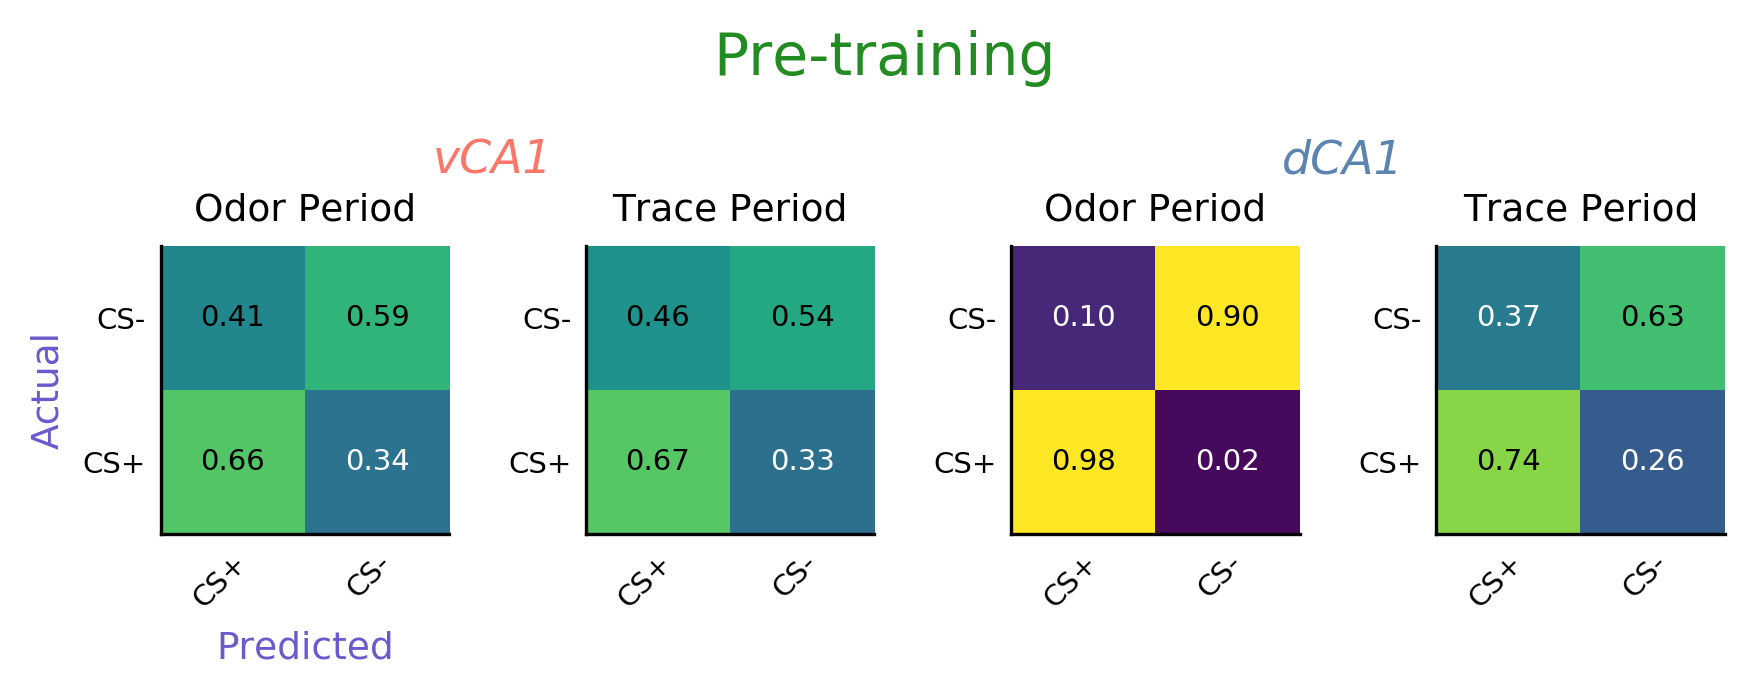

In [98]:
# plot 'em all
sess='expo'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_%s_gmin[i]/np.sum(heatmaps_%s_%s_gmin[i])"%(reg,sess,reg,sess)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor Period',fontsize=9)
ax2.set_title('Trace Period',fontsize=9)
ax3.set_title('Odor Period',fontsize=9)
ax4.set_title('Trace Period',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Pre-training',fontsize=14,color='forestgreen')
pl.tight_layout(h_pad=4)
pl.show()
#fig.savefig('../figures/%s_confmat_dv_1s_expo.pdf'%NOTEBOOK_NAME)

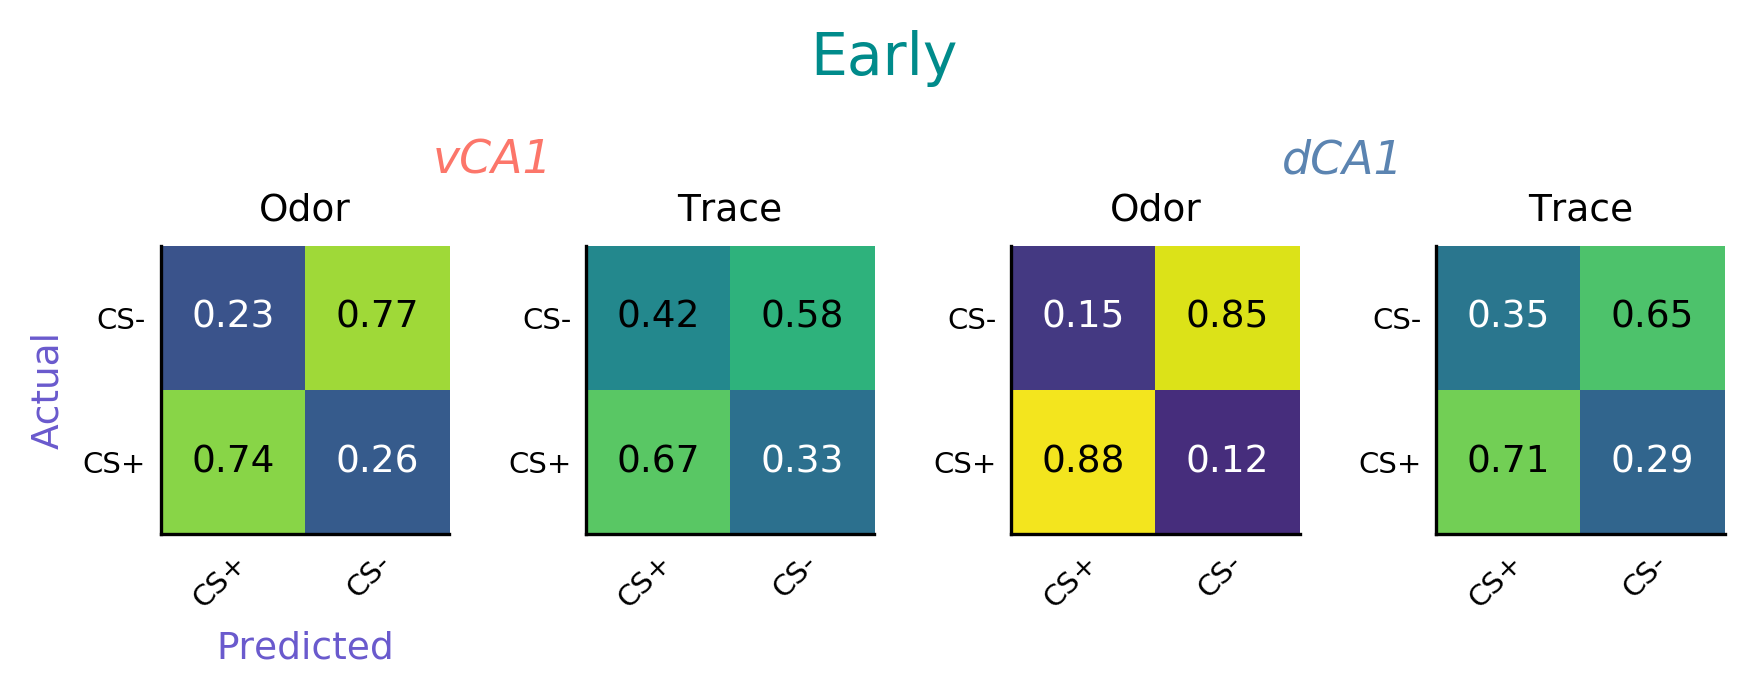

In [105]:
# plot 'em all
sess='pre'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_%s_gmin[i]/np.sum(heatmaps_%s_%s_gmin[i])"%(reg,sess,reg,sess)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Early',fontsize=14,color=dark_co[1])
pl.tight_layout(h_pad=4)
pl.show()
#fig.savefig('../figures/%s_confmat_dv_1s_expo.pdf'%NOTEBOOK_NAME)

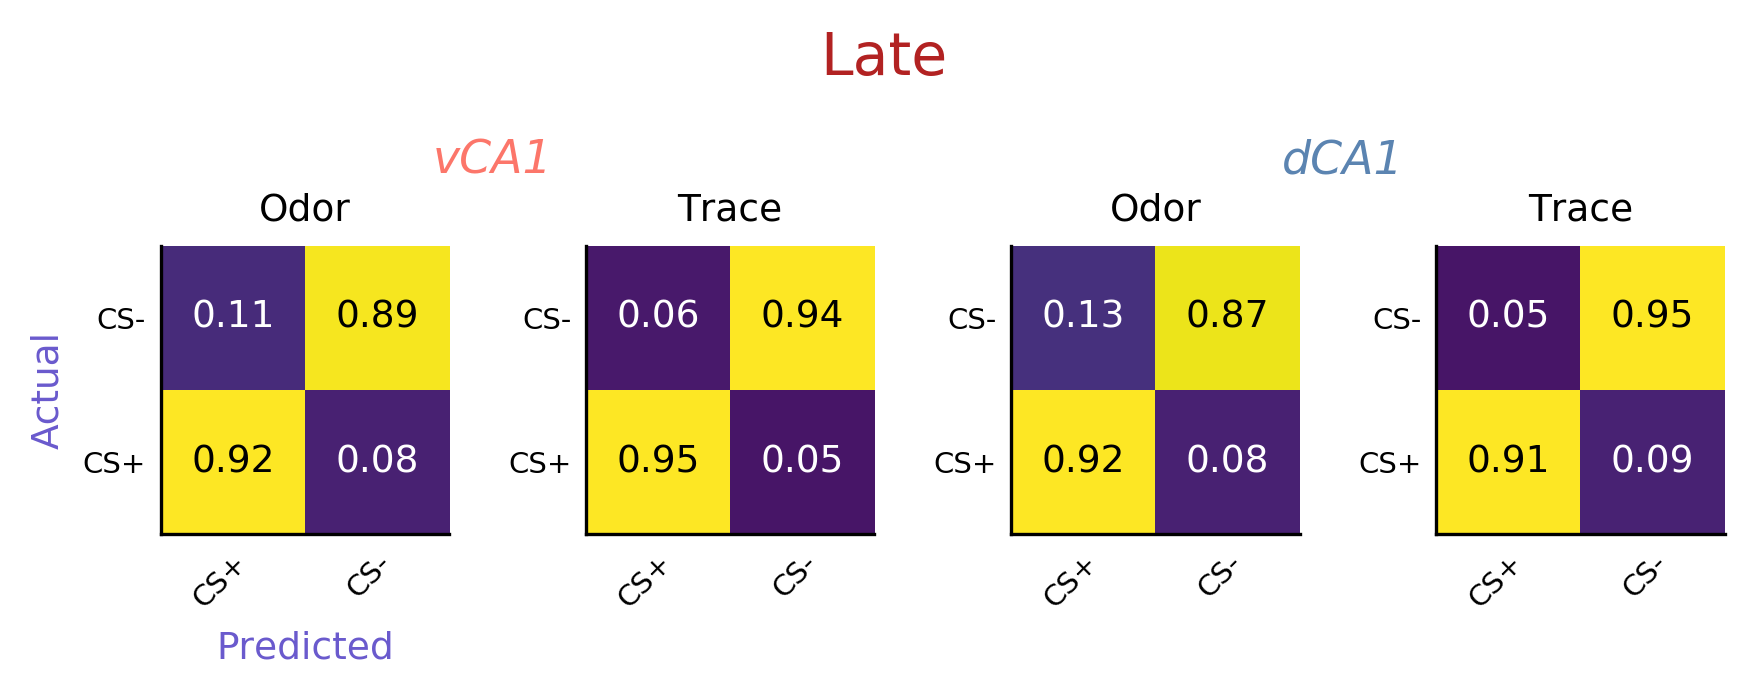

In [107]:
# plot 'em all
sess='post'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_%s_gmin[i]/np.sum(heatmaps_%s_%s_gmin[i])"%(reg,sess,reg,sess)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Late',fontsize=14,color=dark_co[3])
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../final-ish figures/%s_confmat_dv_1s_post.pdf'%NOTEBOOK_NAME)

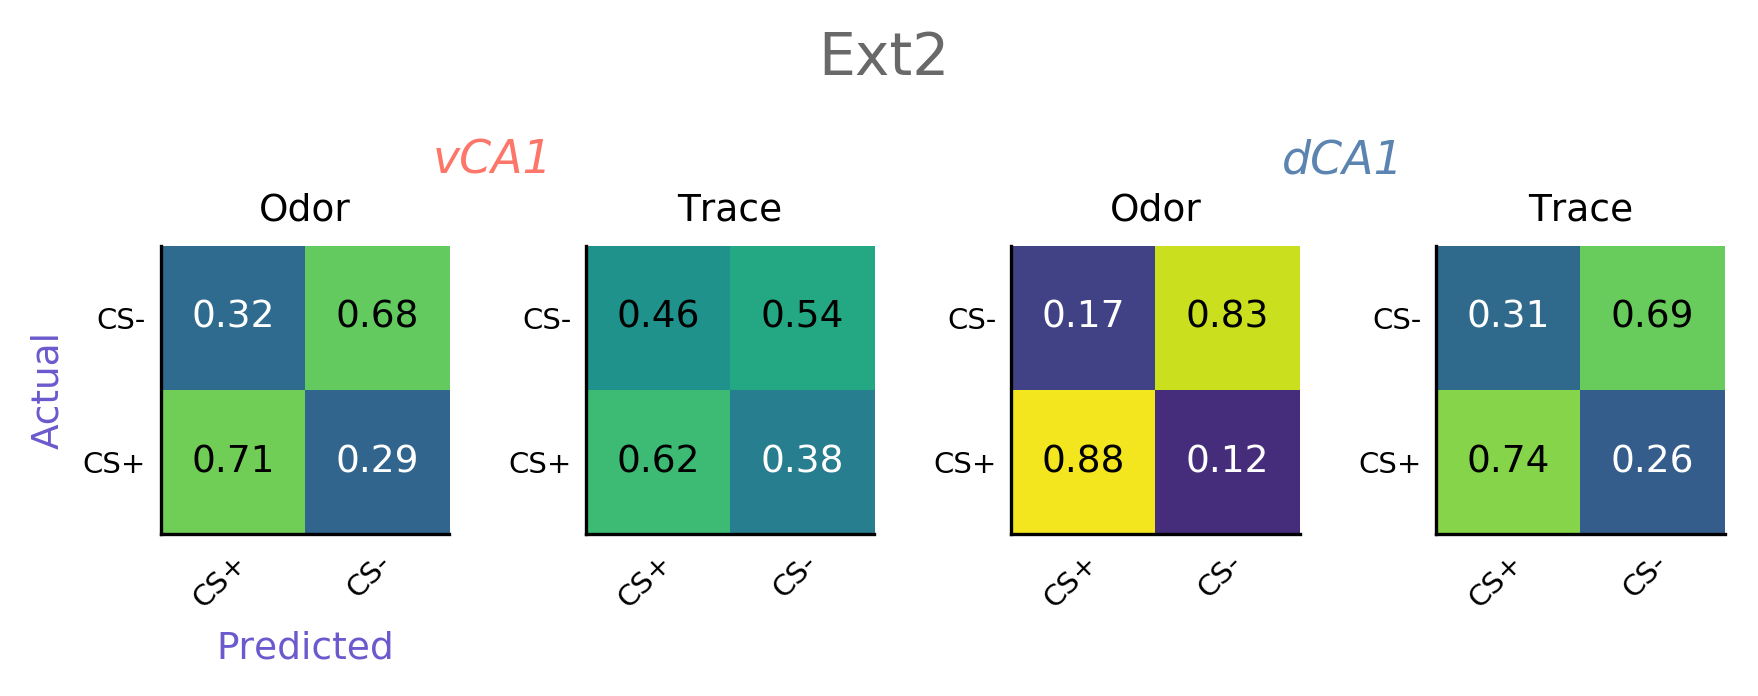

In [109]:
# plot 'em all
sess='ext2'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_%s_gmin[i]/np.sum(heatmaps_%s_%s_gmin[i])"%(reg,sess,reg,sess)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Ext2',fontsize=14,color=dark_co[5])
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../final-ish figures/%s_confmat_dv_1s_ext2.pdf'%NOTEBOOK_NAME)

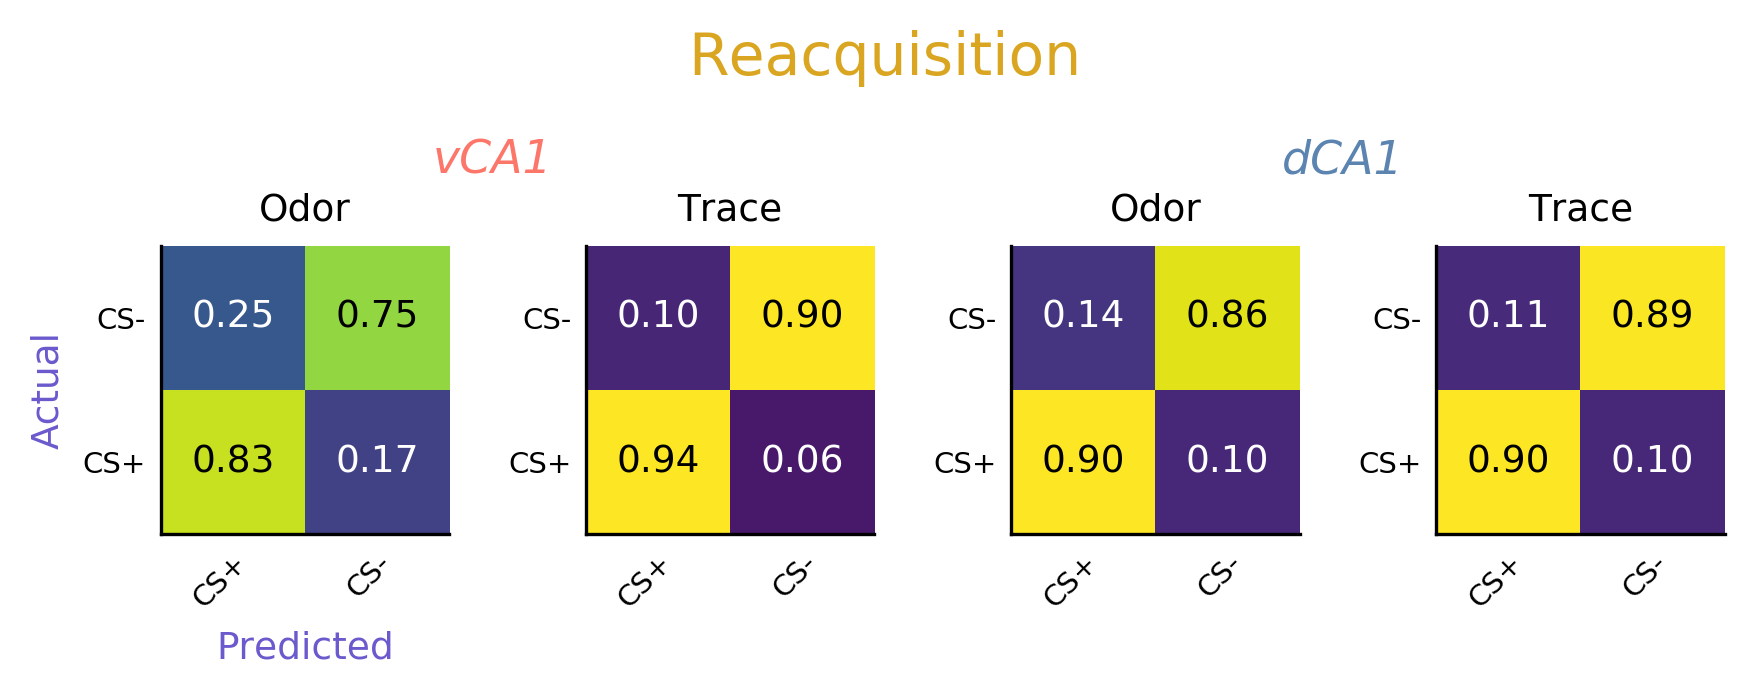

In [110]:
# plot 'em all
sess='renew'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*heatmaps_%s_%s_gmin[i]/np.sum(heatmaps_%s_%s_gmin[i])"%(reg,sess,reg,sess)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Reacquisition',fontsize=14,color=dark_co[-1])
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../final-ish figures/%s_confmat_dv_1s_renew.pdf'%NOTEBOOK_NAME)

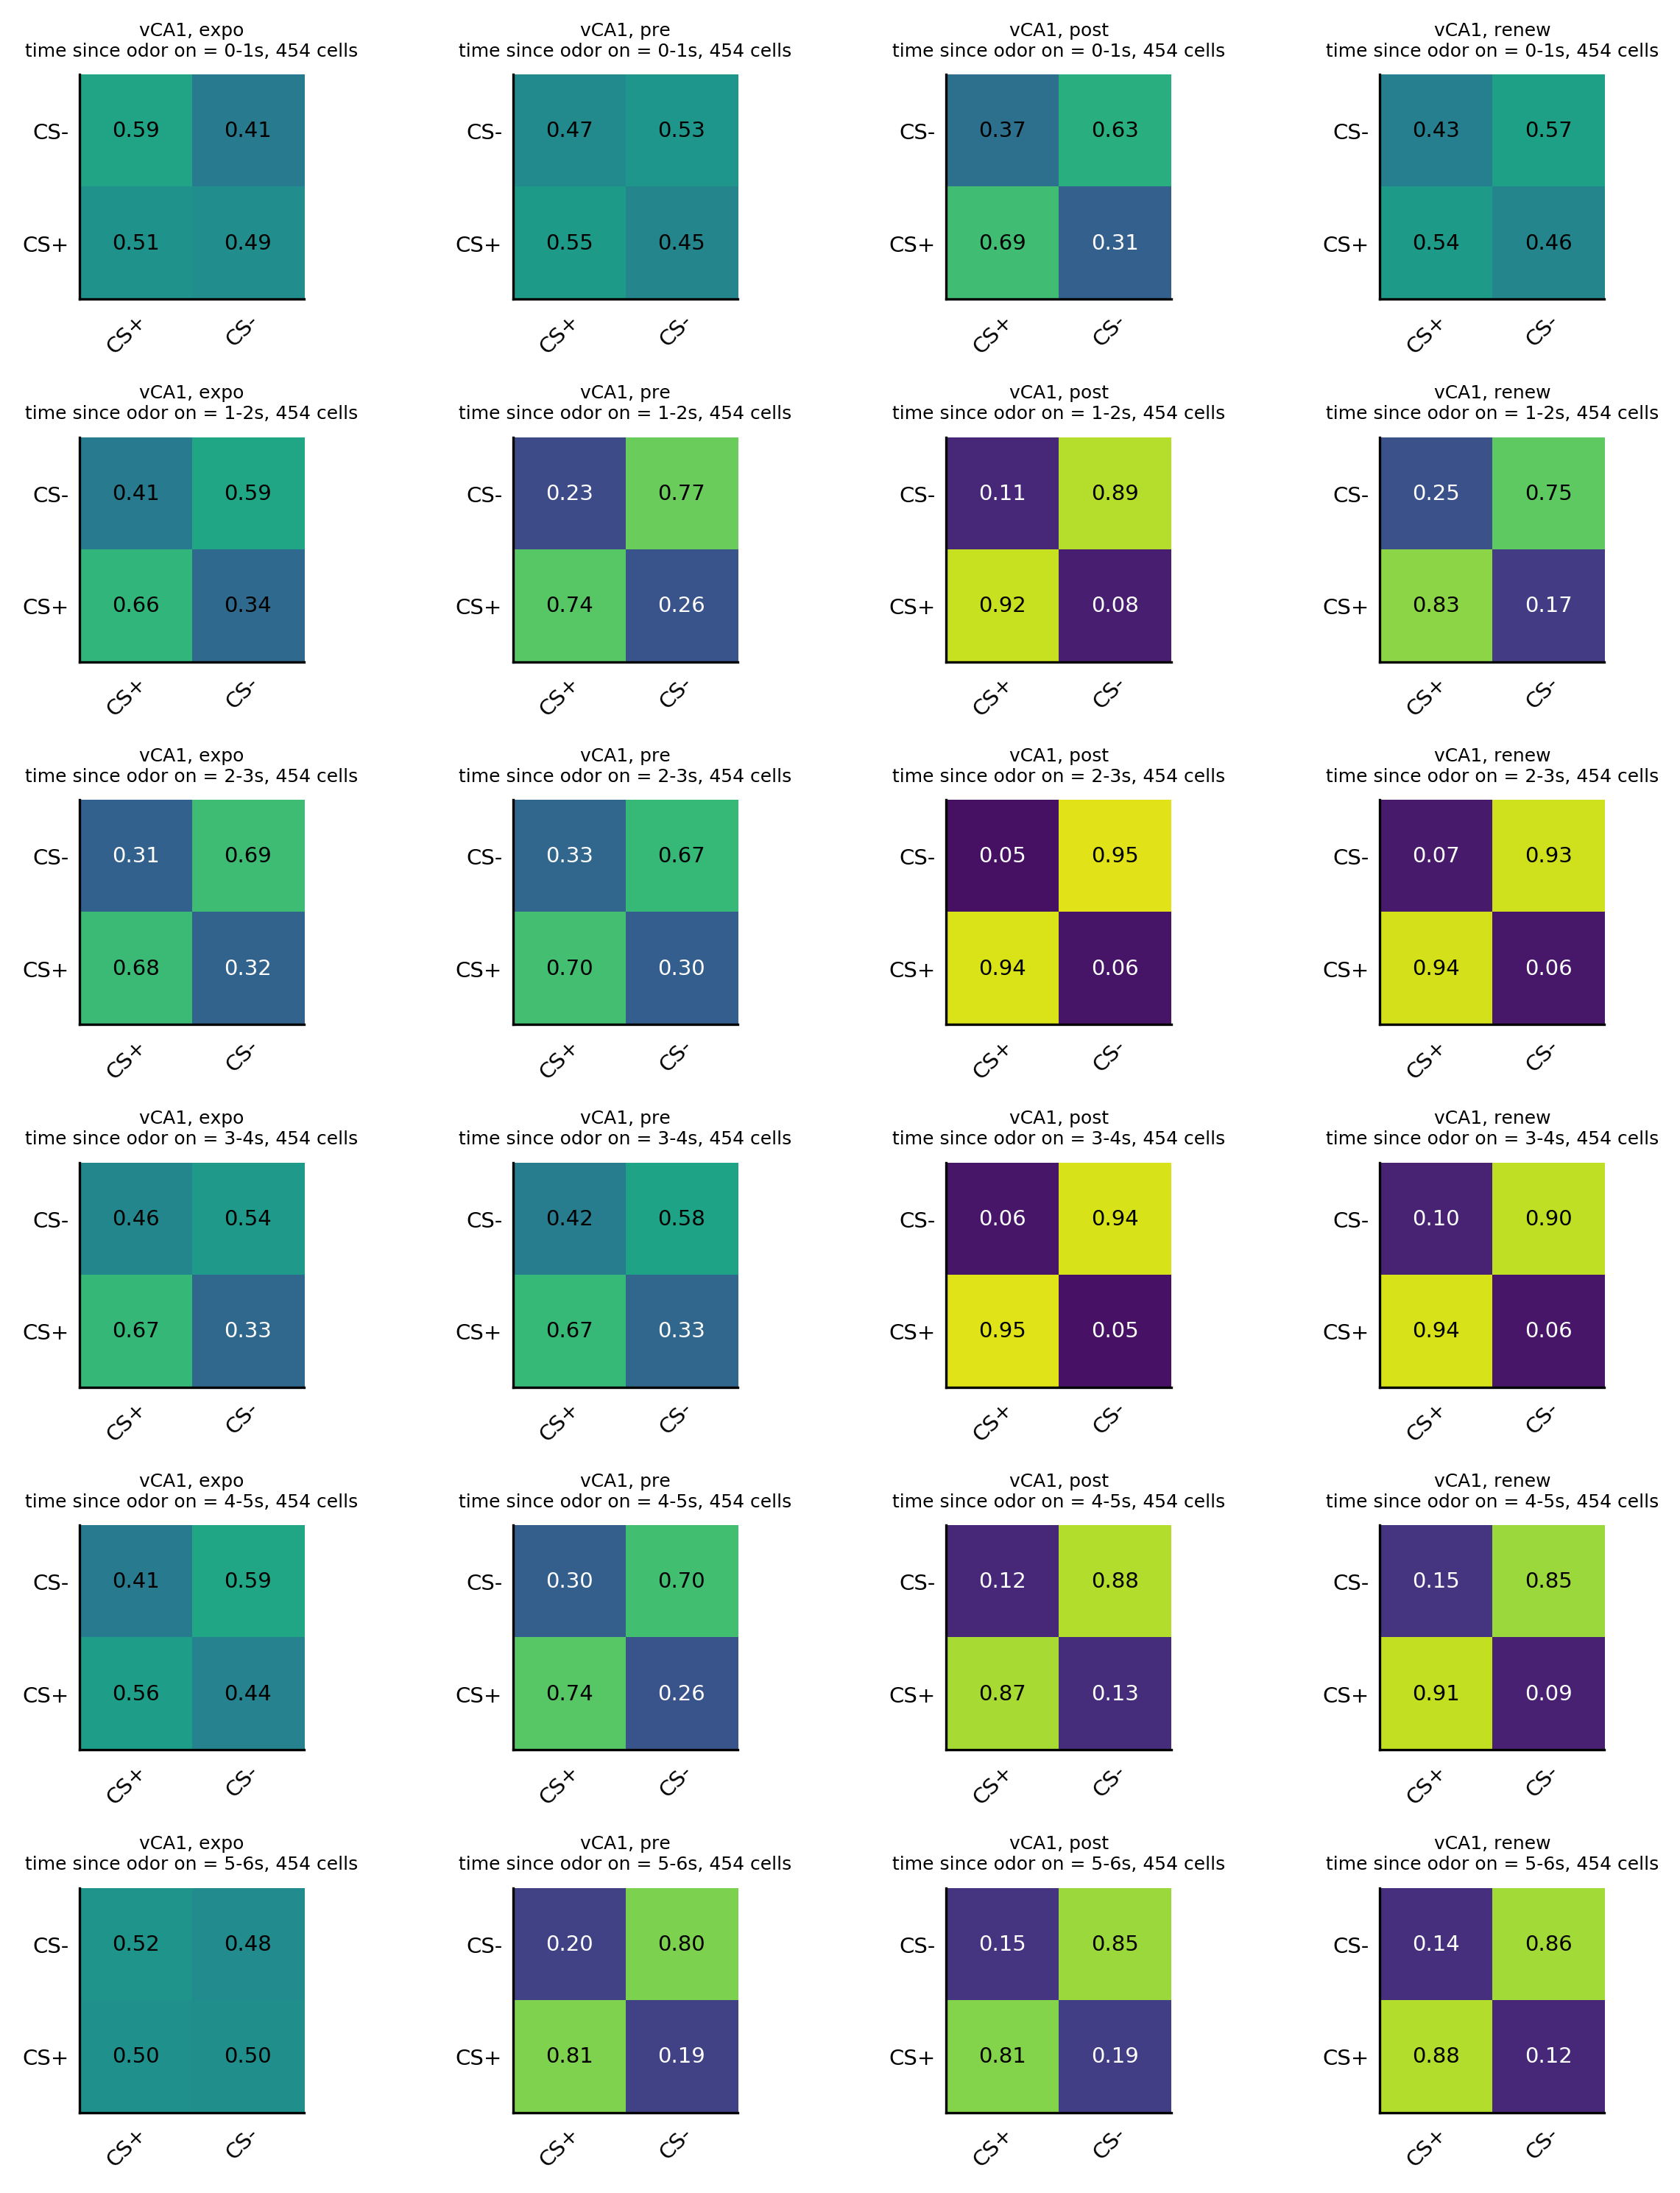

In [88]:
# plot 'em all
fig, ((ax0, ax1, ax2,ax3),(ax4, ax5,ax6, ax7),(ax8,ax9, ax10, ax11),(ax12, ax13, ax14,ax15),(ax16, ax17,ax18,ax19),(ax20,ax21,ax22,ax23)) = pl.subplots(6, 4, figsize=(8, 10))

session='expo'
for i,a in zip(range(5,11),range(0,21,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='pre'
for i,a in zip(range(5,11),range(1,22,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='post'
for i,a in zip(range(5,11),range(2,23,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='renew'
for i,a in zip(range(5,11),range(3,24,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
pl.tight_layout()
pl.show()
fig.savefig('../img/%s_vhpc_ALL.jpg'%NOTEBOOK_NAME)

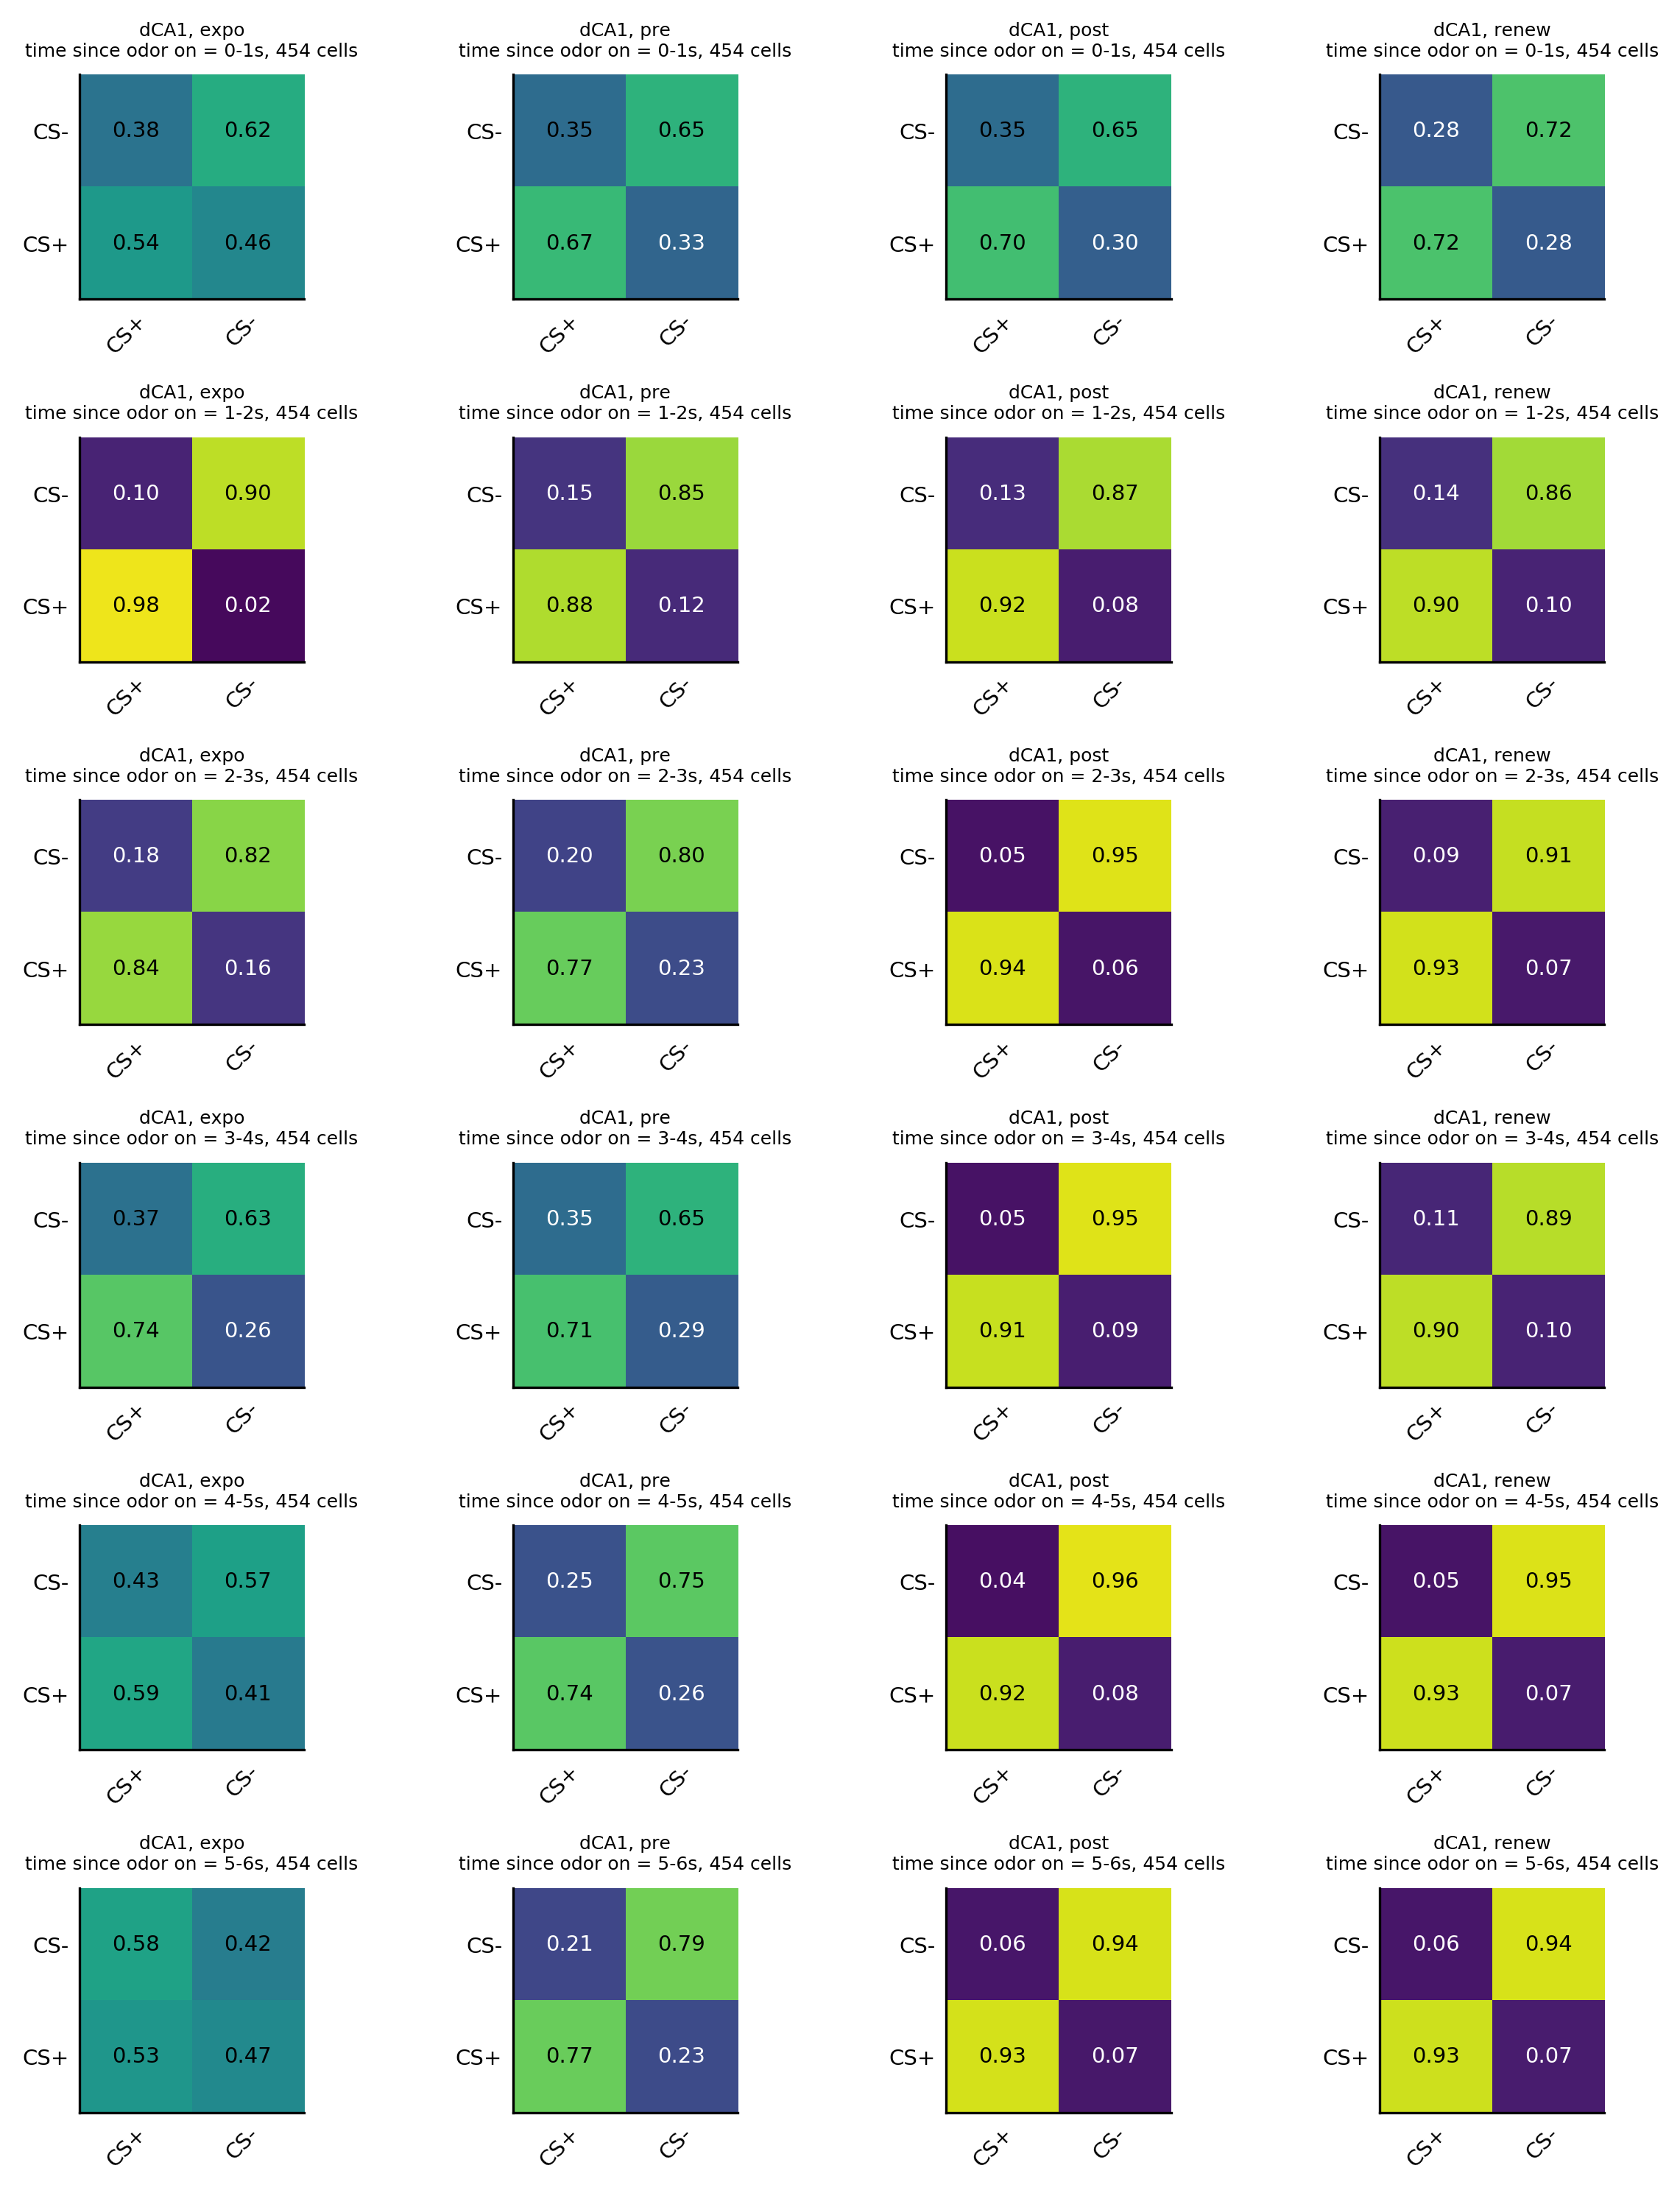

In [89]:
# plot 'em all
fig, ((ax0, ax1, ax2,ax3),(ax4, ax5,ax6, ax7),(ax8,ax9, ax10, ax11),(ax12, ax13, ax14,ax15),(ax16, ax17,ax18,ax19),(ax20,ax21,ax22,ax23)) = pl.subplots(6, 4, figsize=(8, 10))

session='expo'
for i,a in zip(range(5,11),range(0,21,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='pre'
for i,a in zip(range(5,11),range(1,22,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='post'
for i,a in zip(range(5,11),range(2,23,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
session='renew'
for i,a in zip(range(5,11),range(3,24,4)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
pl.tight_layout()
pl.show()
fig.savefig('../img/%s_dhpc_ALL.jpg'%NOTEBOOK_NAME)

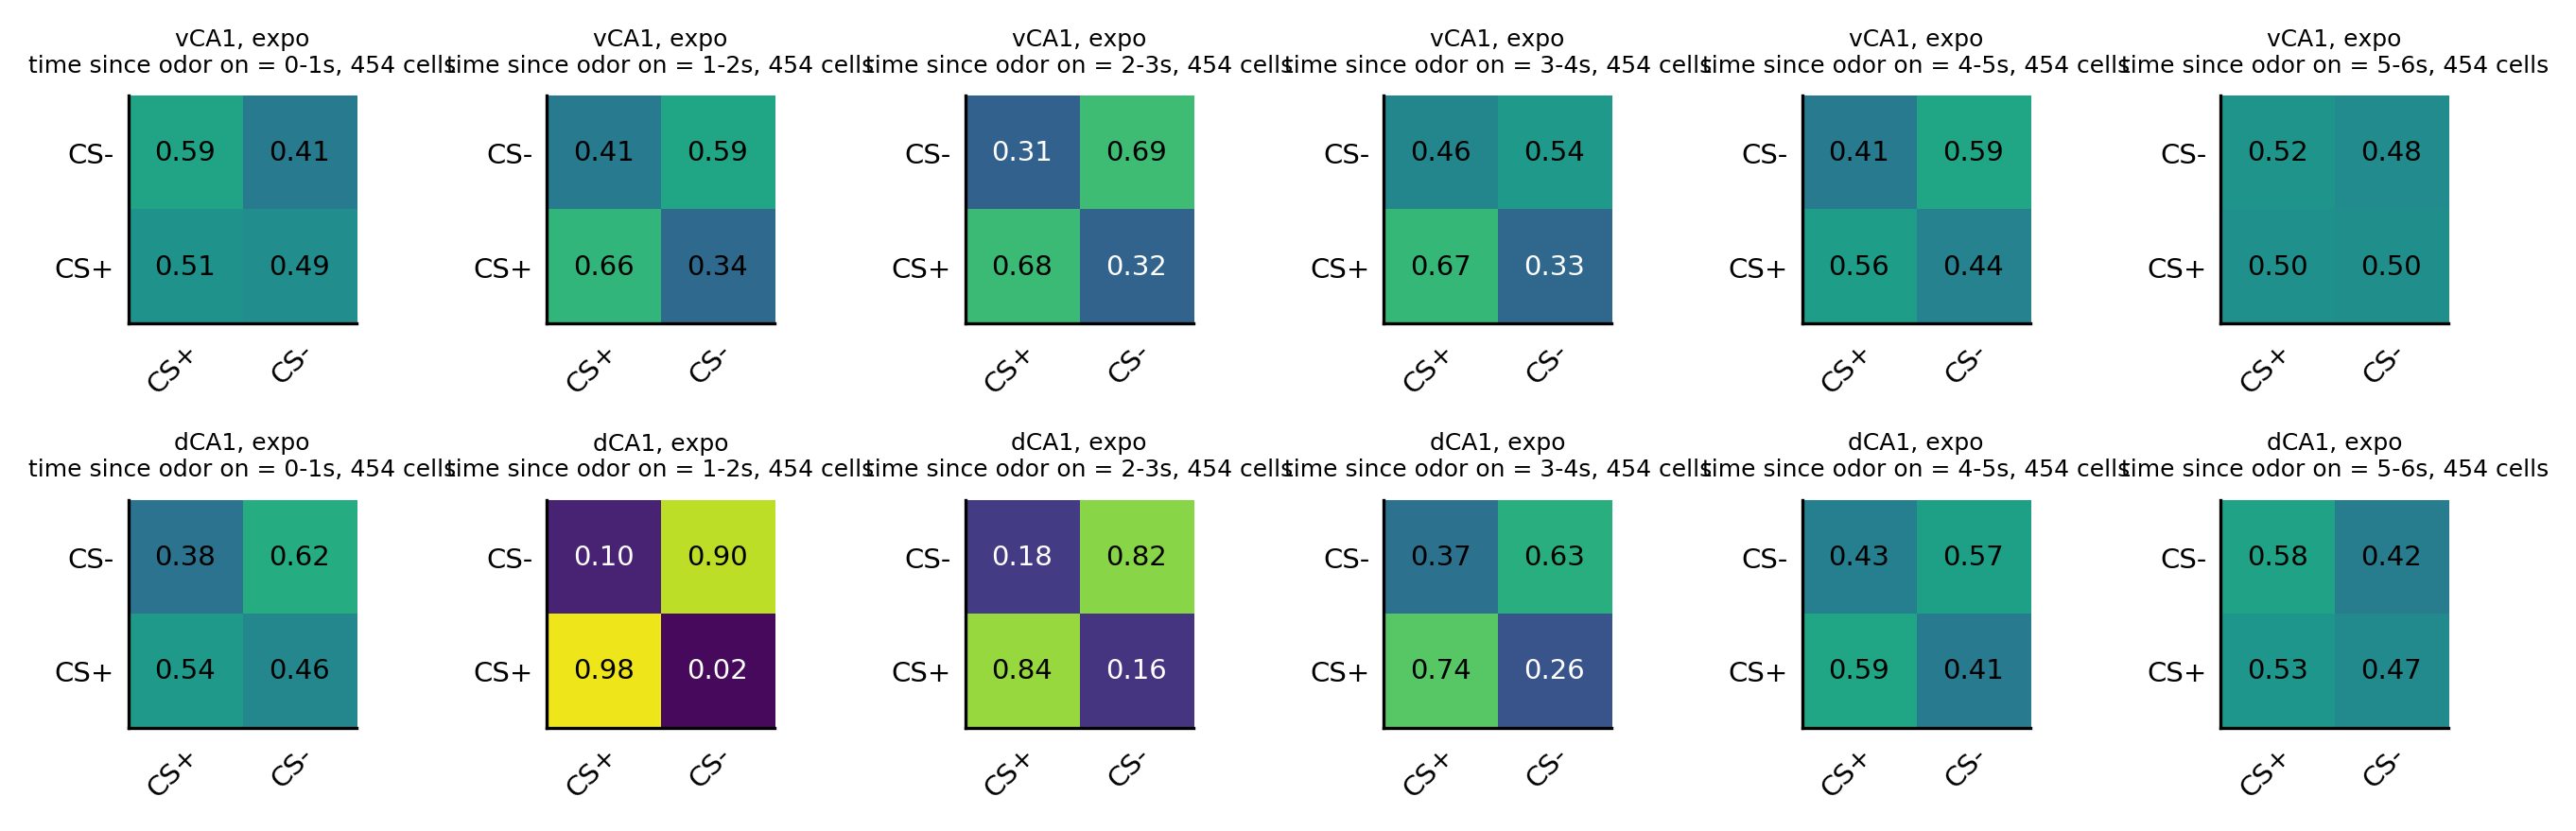

In [101]:
# plot 'em all
fig, ((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = pl.subplots(2, 6, figsize=(9, 3))

session='expo'
for i,a in zip(range(5,11),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
for i,a in zip(range(5,11),range(6,13)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)

pl.tight_layout()
pl.show()
fig.savefig('../final-ish figures/%s_dv_expo.pdf'%NOTEBOOK_NAME)

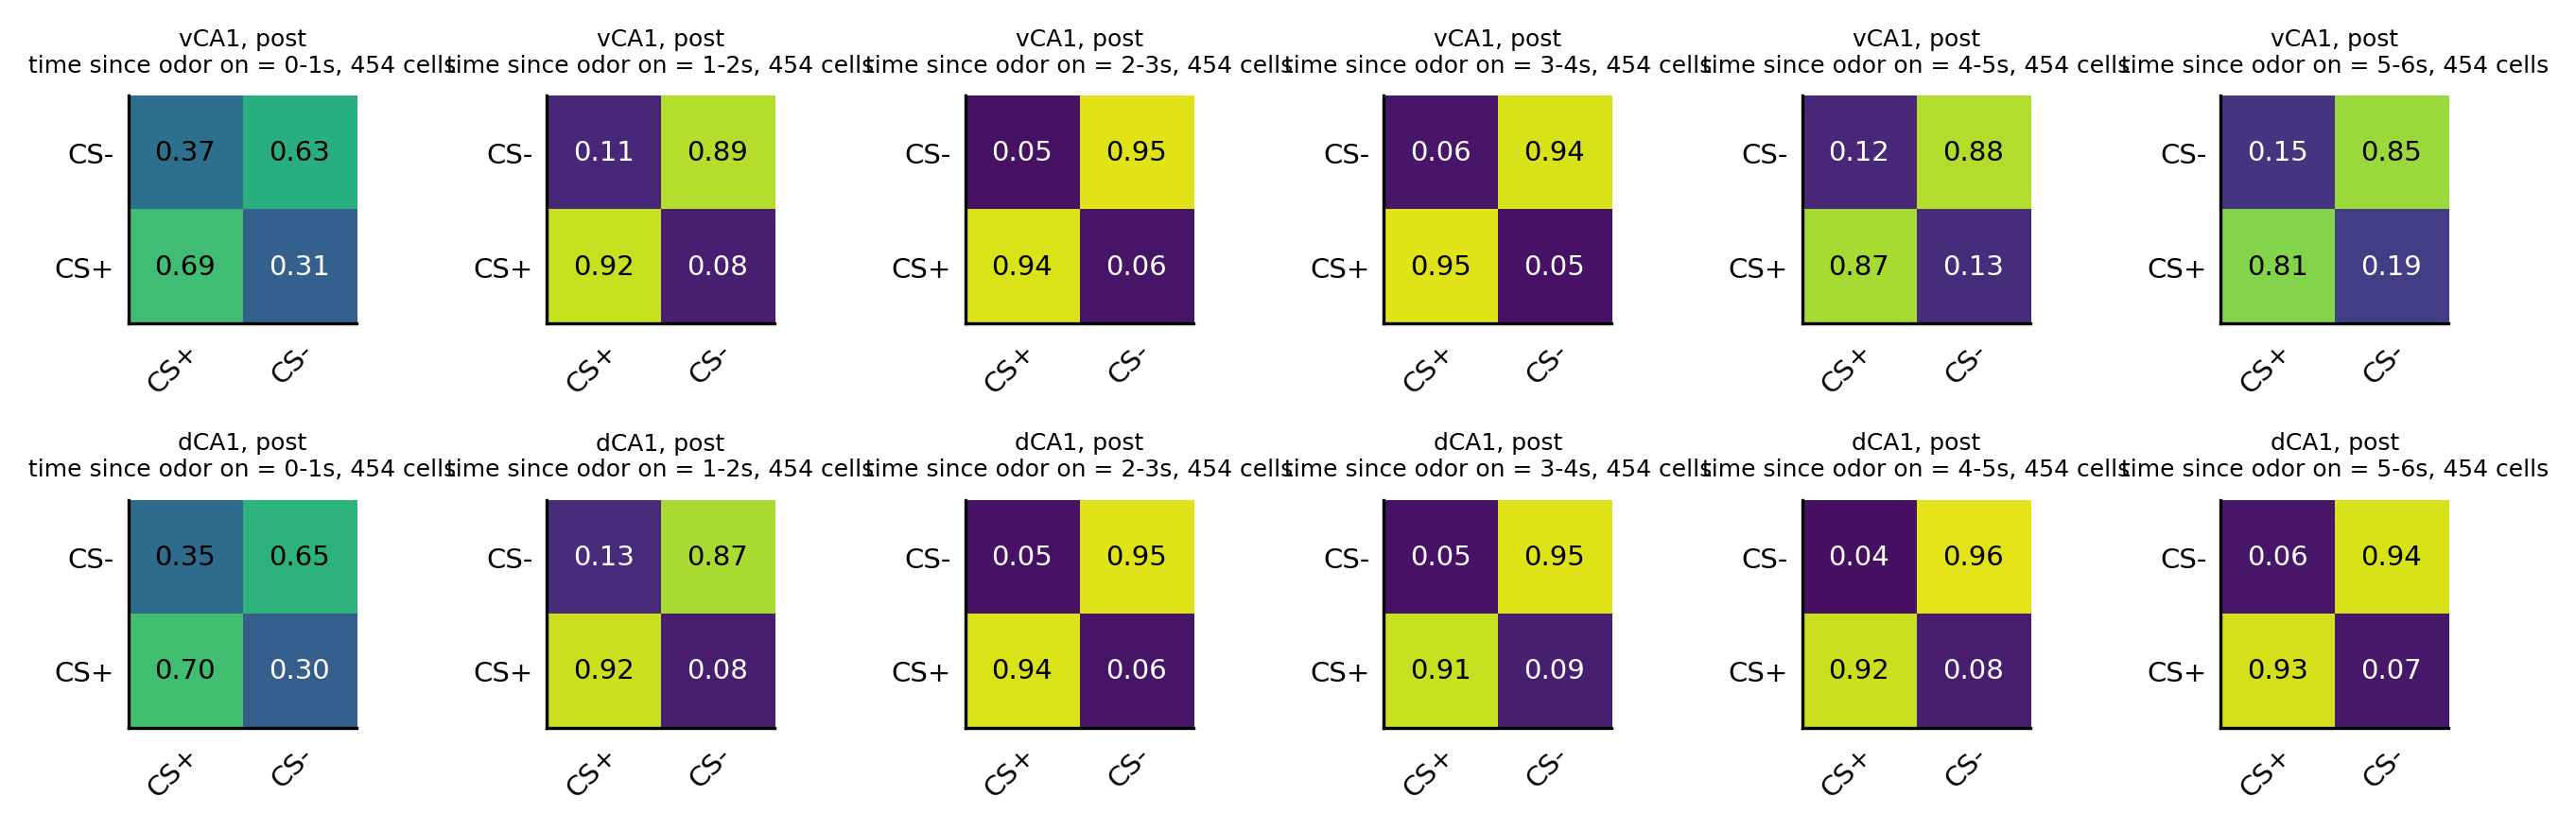

In [102]:
# plot 'em all
fig, ((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = pl.subplots(2, 6, figsize=(9, 3))

session='post'
for i,a in zip(range(5,11),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_vhpc_%s_gmin[i]/np.sum(heatmaps_vhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)
for i,a in zip(range(5,11),range(6,13)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(eval("2.*heatmaps_dhpc_%s_gmin[i]/np.sum(heatmaps_dhpc_%s_gmin[i])"%(session,session)),(['CS+','CS-']),
                 (['CS+','CS-']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dCA1, %s\\ntime since odor on = %s-%ss, 454 cells"'%(session,str(i-5),str(i-4))),fontsize=6)

pl.tight_layout()
pl.show()
fig.savefig('../final-ish figures/%s_dv_post.pdf'%NOTEBOOK_NAME)

In [86]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'np'. Skipping...
